## Predict BOSTON Housing Prices

### 1.import packages & set up notebook

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

session = sagemaker.Session()

role = get_execution_role()

### 2. download dataset

In [3]:
boston = load_boston()

### 3.prepare the data

In [4]:
X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

### 4. Upload files to S3

In [5]:
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [7]:
prefix = 'boston-xgboost-deploy-hl'

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

### 5. Train XGBoost model

In [8]:
container = get_image_uri(session.boto_region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

	get_image_uri(region, 'xgboost', '0.90-1').


In [9]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [10]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-05-29 15:28:36 Starting - Starting the training job...
2020-05-29 15:28:39 Starting - Launching requested ML instances......
2020-05-29 15:29:50 Starting - Preparing the instances for training......
2020-05-29 15:30:53 Downloading - Downloading input data...
2020-05-29 15:31:26 Training - Downloading the training image..Arguments: train
[2020-05-29:15:31:46:INFO] Running standalone xgboost training.
[2020-05-29:15:31:46:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8465.94mb
[2020-05-29:15:31:46:INFO] Determined delimiter of CSV input is ','
[15:31:46] S3DistributionType set as FullyReplicated
[15:31:46] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-05-29:15:31:46:INFO] Determined delimiter of CSV input is ','
[15:31:46] S3DistributionType set as FullyReplicated
[15:31:46] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/validation?format=csv&label_column


2020-05-29 15:31:58 Uploading - Uploading generated training model
2020-05-29 15:31:58 Completed - Training job completed
Training seconds: 65
Billable seconds: 65


### 6. Model deployment

In [11]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!

### 7. test model

In [12]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Y_pred = xgb_predictor.predict(X_test.values).decode('utf-8')

Y_pred = np.fromstring(Y_pred, sep=',')

Text(0.5, 1.0, 'Median Price vs Predicted Price')

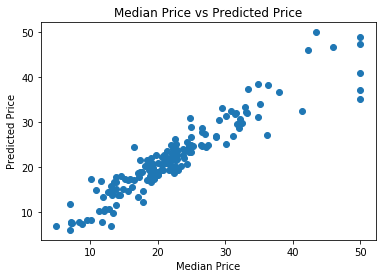

In [13]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

In [14]:
xgb_predictor.delete_endpoint()